# Resaerch Paper of Fraud Detection Algorithm

<p align="right">Jiadai Yu</p>
<p align="right">August 2023</p>

## 1. Introduction

This rapid growth of digital transactions and online payment systems has brought forth a new challenge: online payment fraud. This type of fraud not only jeopardizes the financial security but also poses losses upon individuals and enterprises. By leveraging extensive data, machine learning algorithms can build adaptable fraud detection algorithms, that automaticly identify suspicious transactions.

The costs of alerting users to potential fraud are significantly lower comparing to the consequencial loss of undetected fraud. So, the aim of this paper is to minimize false negatives, ensuring that potential fraudulent activities do not go unnoticed. To realize this objective, I conducted exploratory data analysis, feature engineering, and downsampling to create a balanced training dataset. Subsequently, various algorithms was trained, and random forest classifier achieved the optimal accuracy of 99.37%.

In the final phase, the model was applied to the entire dataset, yielding a accuracy of 98.63% and a mere false negative rate of 0.0002%. This achievement underscores the model can effectively identify potential fraudulent transactions.

## 2. Data Preprocessing

### 2.1 Exploratory Data Analysis

The dataset, sourced from Kaggle (https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection), has already been organized, removing all the missing values and duplicates, it contains 6,362,620 entries and 11 columns, detailed as follows:

1. The `step` column represents a unit of time, where each step corresponds to one hour. The left graph displays a concentrated distribution within the initial 400 hours, exhibiting an approximate evenness without any distinct peak.

2. The `type` column includes five categories of online transactions: `CASH_OUT`, `PAYMENT`, `CASH_IN`, `TRANSFE`R, and `DEBIT`. The pie chart in the middle visualized that `CASH_OUT` and `PAYMENT` share comparable portions, each accounting for roughly 1/3 of total transactions. `CASH_IN` constitutes 22.0%, while `TRANSFER` and `DEBIT` hold minor proportions.  
In addition, there is an interseting observation that only `CASH_OUT` and `TRANSFER` categories include fraud transactions, suggesting a potential connection with the dataset's categorization schema. But no additional screening was conducted to avoid subjective bias.

3. The `amount` column has a skewness of 30.99 and is significantly  right-skewed. However, after employing a logarithmic scale, the distribution was transformed toward approximate normal distribution, demonstrated by the histogram displayed on the right.

Mounted at /content/drive


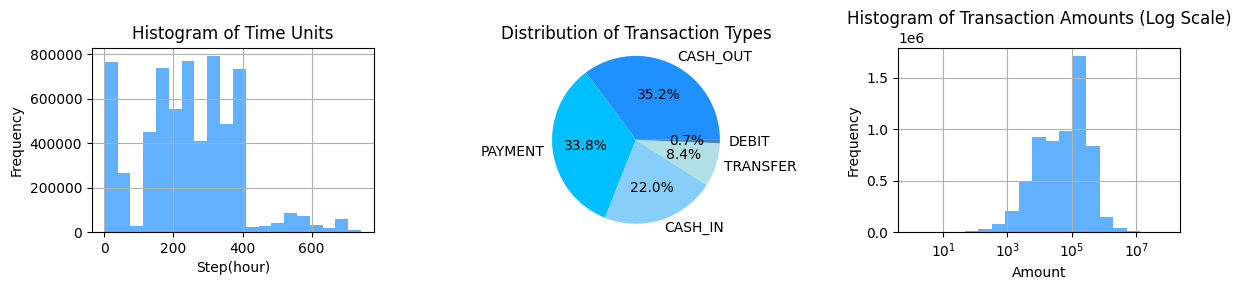

In [4]:
# @title
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/onlinefraud.csv'
df = pd.read_csv(csv_path)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# 1: Time Units
axs[0].hist(df['step'], 20, color='dodgerblue', alpha=0.7)
axs[0].set_xlabel('Step(hour)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Time Units')
axs[0].grid(True)

# 2: Pie plot of Transaction Types
labels = df.type.value_counts().index
sizes = df.type.value_counts().values
colors = ['dodgerblue', 'deepskyblue', 'lightskyblue', 'powderblue', 'steelblue']
axs[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
axs[1].axis('equal')
axs[1].set_title('Distribution of Transaction Types')

# 3: Amounts
axs[2].hist(df['amount'], bins=np.logspace(np.log10(1), np.log10(df['amount'].max()), 20), color='dodgerblue', alpha=0.7)
axs[2].set_xscale('log')  # Set logarithmic scale on x-axis
axs[2].set_xlabel('Amount')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of Transaction Amounts (Log Scale)')
axs[2].grid(True)

plt.tight_layout()
plt.show()


4. The `nameOrig` and `nameDest` columns contain the IDs of transaction senders and recipients. There are only a few duplicate entries within these columns, indicating that the majority of transactions were initiated by different individuals and independent. I deemed these two columns as non-contributory features for fraud detection and excluded them from subsequent training processes.

5. The columns `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest` contain the balances of sender and recipient accounts, before and after transactions. These columns have distributions akin to that of the `amount` column, with less degree of skewness. So the preprocessing steps are also similar, for the sake of brevity, details are not repeated here.

6. Finally, `isFraud` and `isFlaggedFraud` are the labels of our predictive task. Among all transactions, only a mere 0.13% are actually fraud. However, it's noteworthy that the average monetary value of fraudulent transactions is 8.16 times of the average for all transactions. This highlights that while fraud is a rare occurrence, its leads to significant potential losses. To circumvent the risk of overlooking fraudulent transactions, it is imperative to resample the dataset to obtain a more balanced training dataset.

In [5]:
# @title
isFraudPer = df.isFraud.value_counts()[1] / df.shape[0]
print(f'The percentage of transactions that is actually fraud is : {round( isFraudPer*100, 2)} %')

average_amount = df['amount'].mean()
average_amount_fraud = df[df['isFraud'] == 1]['amount'].mean()

fraud_loss = average_amount_fraud / average_amount
print(f'The average monetary value of fraudulent transactions are {round( fraud_loss, 2)} times of the average amount of all transactions.')

The percentage of transactions that is actually fraud is : 0.13 %
The average monetary value of fraudulent transactions are 8.16 times of the average amount of all transactions.


### 2.2 Feature Engineering and Balancing

In this phase, categorical variable `type` was transformed with one-hot coding. Conversely, for the columns `nameOrig` and `nameDest`, according to former EDA, they represent user IDs, lacked numeric significance, thus are unsuitable for training algorithms. On the other hand, numerical variables such as `step`, `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest` remained unaltered, preserving their original state.

After feature engineering, I executed a down-sampling specifically on non-fraud transactions (where `isFraud==0`), to match the number of entries with fraud transactions records (where `isFraud==1`). This balancing strategy ensured parity between the two categories within training dataset.

Following this balancing procedure, I checked the `amount` distribution for both categories of `isFraud` within the balanced dataset. The pattern in the distribution of `amount` remained consistent with previous analyses, demonstrating a nearly normal distribution when plotted on a logarithmic scale, for both `isFraud==0` and `isFraud==1` instances. However, the peak associated with fraud transactions was notably higher in terms of transfer amount compared to normal transactions, further underscoring the fact that fraudulent transactions disproportionately capitalize on large amount transfers, thereby lead to severe financial losses.

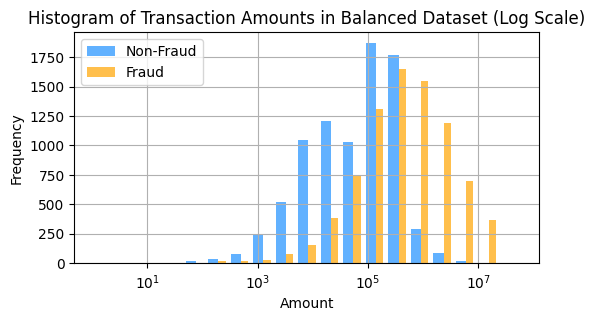

In [6]:
# @title
encoded_df = pd.get_dummies(df, columns=['type'], prefix='type')
encoded_features = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']

encoded_df_Fraud = encoded_df[encoded_df['isFraud']==1]
encoded_df_notFraud = encoded_df[encoded_df['isFraud']==0]
encoded_df_notFraud_down = encoded_df_notFraud.sample(encoded_df.isFraud.value_counts()[1])

balanced_df = pd.concat([encoded_df_Fraud, encoded_df_notFraud_down], axis=0)

plt.figure(figsize=(6, 3))
plt.hist([balanced_df[balanced_df['isFraud'] == 0]['amount'], balanced_df[balanced_df['isFraud'] == 1]['amount']],
         bins=np.logspace(np.log10(1), np.log10(balanced_df['amount'].max()), 20),
         color=['dodgerblue', 'orange'], alpha=0.7, label=['Non-Fraud', 'Fraud'])
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction Amounts in Balanced Dataset (Log Scale)')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

## 3. Machine Learning

In this analysis, I employed the balanced dataset with features: `step`, `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`, and one-hot encoded `type`, and `isFraud` as the target variable. The dataset was divided into training and testing sets with a test size of 0.3. Subsequently, logistic regression, K-nearest neighbors classifier, decision tree classifier, and random forest classifier were trained and evaluated.

To compare the effectiveness of these models, both accuracy and recall were computed. Recall is calculated as TP/(TP+FN), where higher recall indicate a lower false negative rate, indicating that the model can better identify suspicious fraud transactions. The summarized outcomes are tabulated below:

All four algorithms achieved commendable accuracy rates. But due to the complex relationships between features and the target, which are not linear in nature, **logistic regression** exhibited the lowest accuracy. **K-nearest neighbors classifier** displayed improved performance but with room for enhancement. In addition, given the substantial size of the entire dataset, KNN can be computationally expensive, which make it suboptimal.

Meanwhile, the **decision tree classifier** and **random forest classifier** both achieved high accuracy, and the random forest classifier demonstrated enhanced recall closer to 1. This underscores its proficiency in identifying potential fraud cases. Additionally, considering the fact that training dataset is downsampled from original dataset, the random forest classifier's ability to reduce overfitting enhanced its generalizability. Generally speaking, the **random forest classifier** is the most suitable algorithm.

The conclusion section will delve further into the random forest classifier's performance on the generalized dataset, providing a comprehensive conclusion to this study.

In [8]:
# @title
from sklearn.model_selection import train_test_split
x = np.array(balanced_df[encoded_features])
y = np.array(balanced_df[["isFraud"]])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression()
model_LR.fit(xtrain, ytrain)
y_pred_LR = model_LR.predict(xtest)
recall_LR = round(recall_score(ytest, y_pred_LR)*100,2)
accuracy_LR = round(model_LR.score(xtest, ytest)*100,2)

from sklearn.neighbors import KNeighborsClassifier
model_KNN = KNeighborsClassifier()
model_KNN.fit(xtrain, ytrain)
y_pred_KNN = model_KNN.predict(xtest)
recall_KNN = round(recall_score(ytest, y_pred_KNN)*100,2)
accuracy_KNN = round(model_KNN.score(xtest, ytest)*100,2)

from sklearn.tree import DecisionTreeClassifier
model_DT = DecisionTreeClassifier()
model_DT.fit(xtrain, ytrain)
y_pred_DT = model_DT.predict(xtest)
recall_DT = round(recall_score(ytest, y_pred_DT)*100,2)
accuracy_DT = round(model_DT.score(xtest, ytest)*100,2)

from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()
model_RF.fit(xtrain, ytrain)
y_pred_RF = model_RF.predict(xtest)
recall_RF = round(recall_score(ytest, y_pred_RF)*100,2)
accuracy_RF = round(model_RF.score(xtest, ytest)*100,2)

results = {
    'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest'],
    'Recall (%)': [recall_LR, recall_KNN, recall_DT, recall_RF],
    'Accuracy (%)': [accuracy_LR, accuracy_KNN, accuracy_DT, accuracy_RF]
}
results_df = pd.DataFrame(results)
print('Accuracy and Recall of 4 Algorithms')
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-8-677344eb0d4a>:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RF.fit(xtrain, ytrain)


Accuracy and Recall of 4 Algorithms
                 Model  Recall (%)  Accuracy (%)
0  Logistic Regression       89.87         90.67
1  K-Nearest Neighbors       95.72         95.25
2        Decision Tree       98.87         98.90
3        Random Forest       99.56         99.37


## 4. Conclusion

After the aforementioned comparisons, I utilized confusion matrix evaluate the random forest classifier on more detail. On the balanced dataset, the ratio of false positives to false negatives was fairly proportionate, signifying an unbiased performance.

Subsequently, the model was generalized to the entire dataset, comprising 6,362,620 entries. Given the low probability of online payment fraud and the fact that our model was trained on the down-sampled dataset, there was an increase in false positives. This implies that some transactions were erroneously identified as fraud despite being legitimate. Meanwhile, the false negative rate remained notably low at a mere 0.0002%.

When considering practical implications, retaining flagged-as-fraud transactions for subsequent confirmation from the payer is a cost-effective action. Nonetheless, overlooking a fraudulent transaction can lead to financial losses which is hard to recover. Taking both perspectives into consideration, minimizing false negatives is the more prudent strategy. The random forest classifier developed in this research paper effectively fulfills this crucial objective.

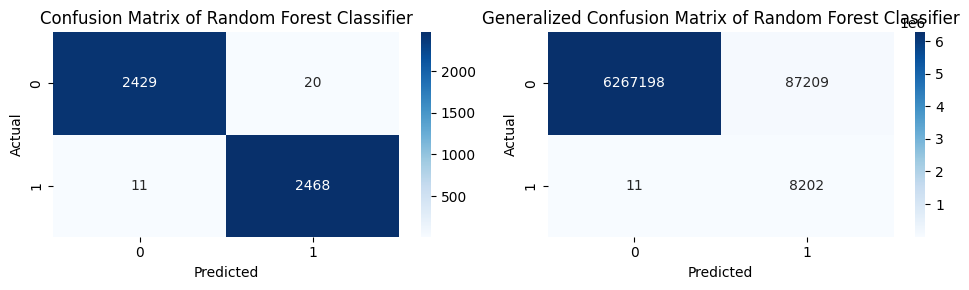

Generalize the random forest classifier to the entire dataset, the accuracy is: 98.63%
Over all false negative rate of the random forest classifier within the entire dataset is: 0.0002%


In [10]:
# @title
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# 1: On the balanced dataset
ypred = model_RF.predict(xtest)
cm_rf = confusion_matrix(ytest, ypred)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(ytest), yticklabels=np.unique(ytest), ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Confusion Matrix of Random Forest Classifier')

# 2: Generlize to entire dataset
X = np.array(encoded_df[encoded_features])
Y = np.array(encoded_df[["isFraud"]])
Ypred = model_RF.predict(X)
cm = confusion_matrix(Y, Ypred)
accuracy = (cm[1,1]+cm[0,0]) / (cm[1,1]+cm[0,0]+cm[0,1]+cm[1,0])
fnr = cm[1,0] / (cm[1,0]+cm[0,0])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(ytest), yticklabels=np.unique(ytest), ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Generalized Confusion Matrix of Random Forest Classifier')

# Display
plt.tight_layout()
plt.show()
print(f'Generalize the random forest classifier to the entire dataset, the accuracy is: {round(accuracy*100,2)}%')
print(f'Over all false negative rate of the random forest classifier within the entire dataset is: {round(fnr*100,4)}%')